# EDA on 3 month weather data from OTPW 

## SUMMARY

1. **Dimensions:**
- There are 1401363 rows and 124 columns in the otpw_weather dataframe
- There are 30528602 rows and 124 columns in the df_weather dataframe
- There are 1401363 rows and 216 columns in the df_otpw dataframe
- There are 1401363 rows and 34 columns in the otpw_weather_test_subset dataframe (variables with less than 80% nulls)
  

2. **Schema:** 
- Integer, float, string and datetime variables

3. **Nulls**
  - Out of the 124 columns in otpw_weather, only 58 columns are not all-nulls. 
  - Of the 58 columns in the subset, columns with most nulls are (see dictionary below)

4. **Histograms**
- Some variables are skewed

5. **Summary statistics**
- No visible outliers

6. **Pearson Correlations**
- Some variables are highly correlated - carry out PCA




## Import libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import seaborn as sns
from pyspark.ml.feature import Imputer


## Setup cluster

In [0]:

blob_container = "261storagecontainer"  
storage_account = "261storage" 
secret_scope = "261_team_6_1_spring24_scope"  
secret_key = "team_6_1_key"  
team_blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net" 


# blob storage is mounted here.
mids261_mount_path = "/mnt/mids-w261"

# SAS Token: Grant the team limited access to Azure Storage resources
spark.conf.set(
    f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
    dbutils.secrets.get(scope=secret_scope, key=secret_key),
)

In [0]:
# # see what's in the blob storage root folder
display(dbutils.fs.ls(f"{team_blob_url}/rg/"))

path,name,size,modificationTime
wasbs://261storagecontainer@261storage.blob.core.windows.net/2015_1YR_OTPW_parquet/,2015_1YR_OTPW_parquet/,0,1710978433000
wasbs://261storagecontainer@261storage.blob.core.windows.net/2015_1YR_OTPW_parquet_test/,2015_1YR_OTPW_parquet_test/,0,1711039243000
wasbs://261storagecontainer@261storage.blob.core.windows.net/2015_1YR_OTPW_parquet_train/,2015_1YR_OTPW_parquet_train/,0,1711039121000
wasbs://261storagecontainer@261storage.blob.core.windows.net/2015_1YR_OTPW_parquet_train_filtered/,2015_1YR_OTPW_parquet_train_filtered/,0,1711075248000
wasbs://261storagecontainer@261storage.blob.core.windows.net/TP/,TP/,0,1710263499000
wasbs://261storagecontainer@261storage.blob.core.windows.net/js/,js/,0,1710564217000
wasbs://261storagecontainer@261storage.blob.core.windows.net/js_test/,js_test/,0,1710692934000
wasbs://261storagecontainer@261storage.blob.core.windows.net/js_weatherstations/,js_weatherstations/,0,1710816939000
wasbs://261storagecontainer@261storage.blob.core.windows.net/juliana_1y_weather_subset/,juliana_1y_weather_subset/,0,1711045847000
wasbs://261storagecontainer@261storage.blob.core.windows.net/juliana_raw_1y_weather_subset/,juliana_raw_1y_weather_subset/,0,1711055700000


In [0]:
# mount
data_BASE_DIR = "dbfs:/mnt/mids-w261/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))

path,name,size,modificationTime
dbfs:/mnt/mids-w261/HW5/,HW5/,0,0
dbfs:/mnt/mids-w261/OTPW_12M/,OTPW_12M/,0,0
dbfs:/mnt/mids-w261/OTPW_1D_CSV/,OTPW_1D_CSV/,0,0
dbfs:/mnt/mids-w261/OTPW_36M/,OTPW_36M/,0,0
dbfs:/mnt/mids-w261/OTPW_3M/,OTPW_3M/,0,0
dbfs:/mnt/mids-w261/OTPW_3M_2015.csv,OTPW_3M_2015.csv,1500620247,1679772070000
dbfs:/mnt/mids-w261/OTPW_60M/,OTPW_60M/,0,0
dbfs:/mnt/mids-w261/airport-codes_csv.csv,airport-codes_csv.csv,6232459,1677623514000
dbfs:/mnt/mids-w261/datasets_final_project/,datasets_final_project/,0,0
dbfs:/mnt/mids-w261/datasets_final_project_2022/,datasets_final_project_2022/,0,0


## Load data

%md
## 1 Schema

In [0]:
# OTPW 3 month data csv
df_otpw = spark.read.format("csv").option("header", "true").load(f"dbfs:/mnt/mids-w261/OTPW_3M_2015.csv")
print(f'There are {df_otpw.count()} rows and {len(df_otpw.columns)} columns in the df_otpw dataframe')


There are 1401363 rows and 216 columns in the df_otpw dataframe


In [0]:
# and then what is this??? Vini says: use either, there is a slight difference
df_otpw_not_csv = spark.read.format("csv").option("header", "true").load(f"dbfs:/mnt/mids-w261/OTPW_3M/")
print(f'There are {df_otpw_not_csv.count()} rows and {len(df_otpw_not_csv.columns)} columns in the df_otpw_not_csv dataframe')


There are 3840009 rows and 216 columns in the df_otpw_not_csv dataframe


In [0]:
# Load weather data to check for relevant columns in the OTPW dataframe
# Weather data
df_weather = spark.read.parquet(f"dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_3m/")

## 2. Dimensions

- All variables are typecast as string. 
- We should typecast them to their original types

In [0]:
# Select only weather variables and check dimensions again
otpw_weather = df_otpw.select([col for col in df_weather.columns])

print(f'There are {otpw_weather.count()} rows and {len(otpw_weather.columns)} columns in the otpw_weather dataframe')
print(f'There are {df_weather.count()} rows and {len(df_weather.columns)} columns in the df_weather dataframe')
print(f'There are {df_otpw.count()} rows and {len(df_otpw.columns)} columns in the df_otpw dataframe')


There are 1401363 rows and 124 columns in the otpw_weather dataframe
There are 30528602 rows and 124 columns in the df_weather dataframe
There are 1401363 rows and 216 columns in the df_otpw dataframe


## 2.5 Change datatype for string columns which are actually numeric

- HourlyPressureChange (has a + before some numbers), HourlyPrecipitation (find out what T means), HourlyWindDirection (find out what VRB means), DailyPrecipitation (find out T), DailySnowfall (find out T)

- station isn't INT (I don't know why, though), introducing NULLs when typecasting it. 
otpw_weather.select('STATION').distinct().show()

In [0]:
# type cast as integers
this_is_int = ['SOURCE', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyPressureTendency', 'HourlyRelativeHumidity', 'HourlyWetBulbTemperature', 'HourlyWindGustSpeed', 'HourlyWindSpeed', 'Sunrise', 'Sunset', 'DailyAverageDewPointTemperature','DailyAverageDryBulbTemperature', 'DailyAverageRelativeHumidity', 'DailyCoolingDegreeDays', 'DailyHeatingDegreeDays', 'DailyMaximumDryBulbTemperature', 'DailyMinimumDryBulbTemperature', 'DailyPeakWindDirection', 'DailyPeakWindSpeed', 'DailySnowDepth', 'DailySustainedWindDirection', 'DailySustainedWindSpeed', 'BackupElevation', 'YEAR']

this_is_float = ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'HourlyAltimeterSetting', 'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility', 'DailyAverageSeaLevelPressure', 'DailyAverageStationPressure', 'DailyAverageWindSpeed', 'DailyDepartureFromNormalAverageTemperature', 'DailyPrecipitation', 'DailySnowfall', 'BackupDistance', 'BackupLatitude', 'BackupLongitude']

In [0]:
#typecast as int or float
otpw_weather_test = otpw_weather.select(*[
    F.col(c).cast('int').alias(c) if c in this_is_int else
    F.col(c).cast('float').alias(c) if c in this_is_float else
    F.col(c)
    for c in otpw_weather.columns
])

In [0]:
# change date to date
otpw_weather = otpw_weather.withColumn('DATE', F.to_date('DATE'))

## 3. Null values


In [0]:
# find out which columns are all nulls 
numrows = otpw_weather.count()

# Get the number of null values for each column
otpw_null_counts_dict = otpw_weather.select(
        [F.sum(F.col(c).isNull().cast("integer")).alias(c) for c in otpw_weather.columns]
    ).collect()[0].asDict()

In [0]:
# drop columns which are all nulls
columns_to_drop = [col for col, null_count in otpw_null_counts_dict.items() if null_count == numrows]


In [0]:
print(f'{len(columns_to_drop)} of the weather variables are all nulls')


66 of the weather variables are all nulls


In [0]:
otpw_weather_test_subset = otpw_weather_test.select(*[F.col(c) for c in otpw_weather_test.columns if c not in columns_to_drop])

Select variables which have less than 100% nulls and checkpoint

In [0]:
numrows = otpw_weather_test_subset.count()

# nulls in subset weather data
nulls_otpw_weather_test_subset_dict = otpw_weather_test_subset.select(
        [F.sum(F.col(c).isNull().cast("integer")).alias(c) for c in otpw_weather_test_subset.columns]
    ).collect()[0].asDict()

# calculate percentage of rows with null values
updated_dict = {k: round((v / numrows),2) * 100 for k, v in nulls_otpw_weather_test_subset_dict.items()}

# select variables with fewer than 80% nulls
selected_keys = [k for k, v in updated_dict.items() if v < 100]
# selected_keys


otpw_weather_test_subset = otpw_weather_test_subset.select(selected_keys)



In [0]:
# HourlyPrecipitation: **Change T to 0** (signifies trace amount)

otpw_weather_test_subset = otpw_weather_test_subset.withColumn('HourlyPrecipitation', F.when(otpw_weather_test_subset.HourlyPrecipitation=='T', 0).otherwise(otpw_weather_test_subset.HourlyPrecipitation))

#typecast as numeric
mycol = ['HourlyPrecipitation']

for column in mycol:
    otpw_weather_test_subset = otpw_weather_test_subset.withColumn(f"{column}", F.col(column).cast("float"))


In [0]:
# change VRB (variable wind direction) in wind direction to 999
otpw_weather_test_subset = otpw_weather_test_subset.withColumn('HourlyWindDirection', F.when(otpw_weather_test_subset.HourlyWindDirection=='VRB', 999).otherwise(otpw_weather_test_subset.HourlyWindDirection))

#typecast as numeric
mycol = ['HourlyWindDirection']

for column in mycol:
    otpw_weather_test_subset = otpw_weather_test_subset.withColumn(f"{column}", F.col(column).cast("float"))


In [0]:
# Hourly Pressure Change - typecast to float 

#typecast as numeric
mycol = ['HourlyPressureChange']

for column in mycol:
    otpw_weather_test_subset = otpw_weather_test_subset.withColumn(f"{column}", F.col(column).cast("float"))


### Checkpoint otpw_weather_test_subset
- variables which have less than 100% nulls
- variables typecast to their proper type (int, float, str or date)
- some data cleaning for numeric variables with some string information. 


In [0]:
# Checkpoint the DataFrame
otpw_weather_test_subset.write.mode("overwrite").parquet(f"{team_blob_url}/juliana_temp")

In [0]:
# Load checkpointed dataframe
otpw_weather_test_subset = spark.read.parquet( f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net/juliana_temp" )


In [0]:
print(f'There are {otpw_weather_test_subset.count()} rows and {len(otpw_weather_test_subset.columns)} columns in the otpw_weather_test_subset dataframe')


There are 1401363 rows and 34 columns in the otpw_weather_test_subset dataframe


## 4. Histograms

Columns to drop based on very skewed data:
- Hourly precipitation **DROP**
- Source **DROP**
- Hourly Visibility  **DROP**
- Backup distance **DROP**

### Numeric Variables:
- LATITUDE: Latitude
- LONGITUDE: Longitude
- ELEVATION: Elevation
- SOURCE: 
- HourlyAltimeterSetting: The pressure value to which an aircraft altimeter is set so that it will indicate the altitude relative to mean sea level of an aircraft on the ground at the location for which the value was determined. **DROP - COLINEARITY**
- HourlyDewPointTemperature:The temperature to which a given parcel of air must be cooled at constant pressure and water vapor
- HourlyDryBulbTemperature: This is the dry-bulb temperature and is commonly used as the standard air temperature
reported. **DROP - COLINEARITY**
- HourlyPrecipitation: The total hourly precipitation amount for the sensor. T represents trace amounts **DROP - HIGHLY SKEWED**
- HourlyPressureTendency:Pressure tendency (In general a 0 through 3 here indicates an increase in pressure over previous 3 hours and a 5 through 8 indicates a decrease over the previous 3 hours and 4 indicates no change during the previous 3 hours). **DROP - CUMMULATIVE, NOT HOURLY**
- HourlyRelativeHumidity: The identifier that indicates an observation of relative humidity and temperature measured at the relative humidity instrument. 
- HourlySeaLevelPressure: Hourly average sea level pressure (in inches of mercury, to hundredths) **DROP - COLINEALITY**
- HourlyStationPressure:
- HourlyVisibility:
- HourlyWetBulbTemperature:
- HourlyWindDirection: Wind direction from true north using compass directions (e.g. 360 = true north, 180 = south, 270 =
west, etc.). Note: A direction of “000” is given for calm winds. VRB changed to 999
- HourlyWindSpeed: Speed of the wind at the time of observation
- BackupDistance: additional direction information on wind distance from additional station **DROP - HIGHLY SKEWED**
- BackupElevation: additional direction information on elevation from additional station **DROP IF STATION IS TOO FAR AWAY**
- BackupLatitude: additional station latitude **DROP IF STATION IS TOO FAR AWAY**
- BackupLongitude:additional station longitude  **DROP IF STATION IS TOO FAR AWAY**

In [0]:
# describe only numeric columns (minus year)
numeric_cols = [col for col, dtype in otpw_weather_test_subset.dtypes if dtype in ('int', 'float')]
numeric_subset = otpw_weather_test_subset.select(*[F.col(c) for c in numeric_cols if c != 'YEAR'])

print(f'There are {numeric_subset.count()} rows and {len(numeric_subset.columns)} columns in the numeric_subset dataframe')
display(numeric_subset.describe())

There are 1401363 rows and 21 columns in the numeric_subset dataframe


summary,LATITUDE,LONGITUDE,ELEVATION,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindSpeed,BackupDistance,BackupElevation,BackupLatitude,BackupLongitude
count,1401363,1401363,1401363,1401351,1337974,1396373,1396290,1241666,471407,471407,1396608,1247789,1391549,1395162,1391071,1395292,1396692,502464,366060,383566,383566
mean,36.44793051787177,-95.31441957156241,254.23922358199434,6.845469122296984,30.121501825755566,32.178502448844256,47.39732720280171,0.0023032522257133647,0.0013680535274263612,4.391328512304654,60.50087211300522,30.13000645398759,29.227887037781613,9.007992118780699,40.87331200204734,209.48164971919857,8.954836141396958,390.72800442023475,1681.251841228214,37.719592414547215,-103.43900938317451
stddev,5.943325212683787,17.99214225262371,407.06377095700833,0.6292906552436668,0.20081071787756619,19.18455103357275,19.448690237472395,0.015832142565232542,0.05032599335727855,2.7950930537438015,22.051695719746224,0.2097999780510066,1.3501513523888173,2.4062120764065056,16.79303540675697,183.70318676916176,5.716072930240639,1389.9103636675056,1916.7706569618074,6.431866885990602,18.95181917102625
min,17.6997,-176.65,0.3,1,28.62,-38,-40,0.0,-0.31,0,3,28.63,22.22,0.0,-32,0.0,0,0.0625,4,19.7206,-165.4397
max,71.2834,-64.8125,2353.1,7,31.09,76,99,1.69,0.31,9,100,31.18,30.96,25.0,78,999.0,48,7500.0,7002,71.2869,-70.9803


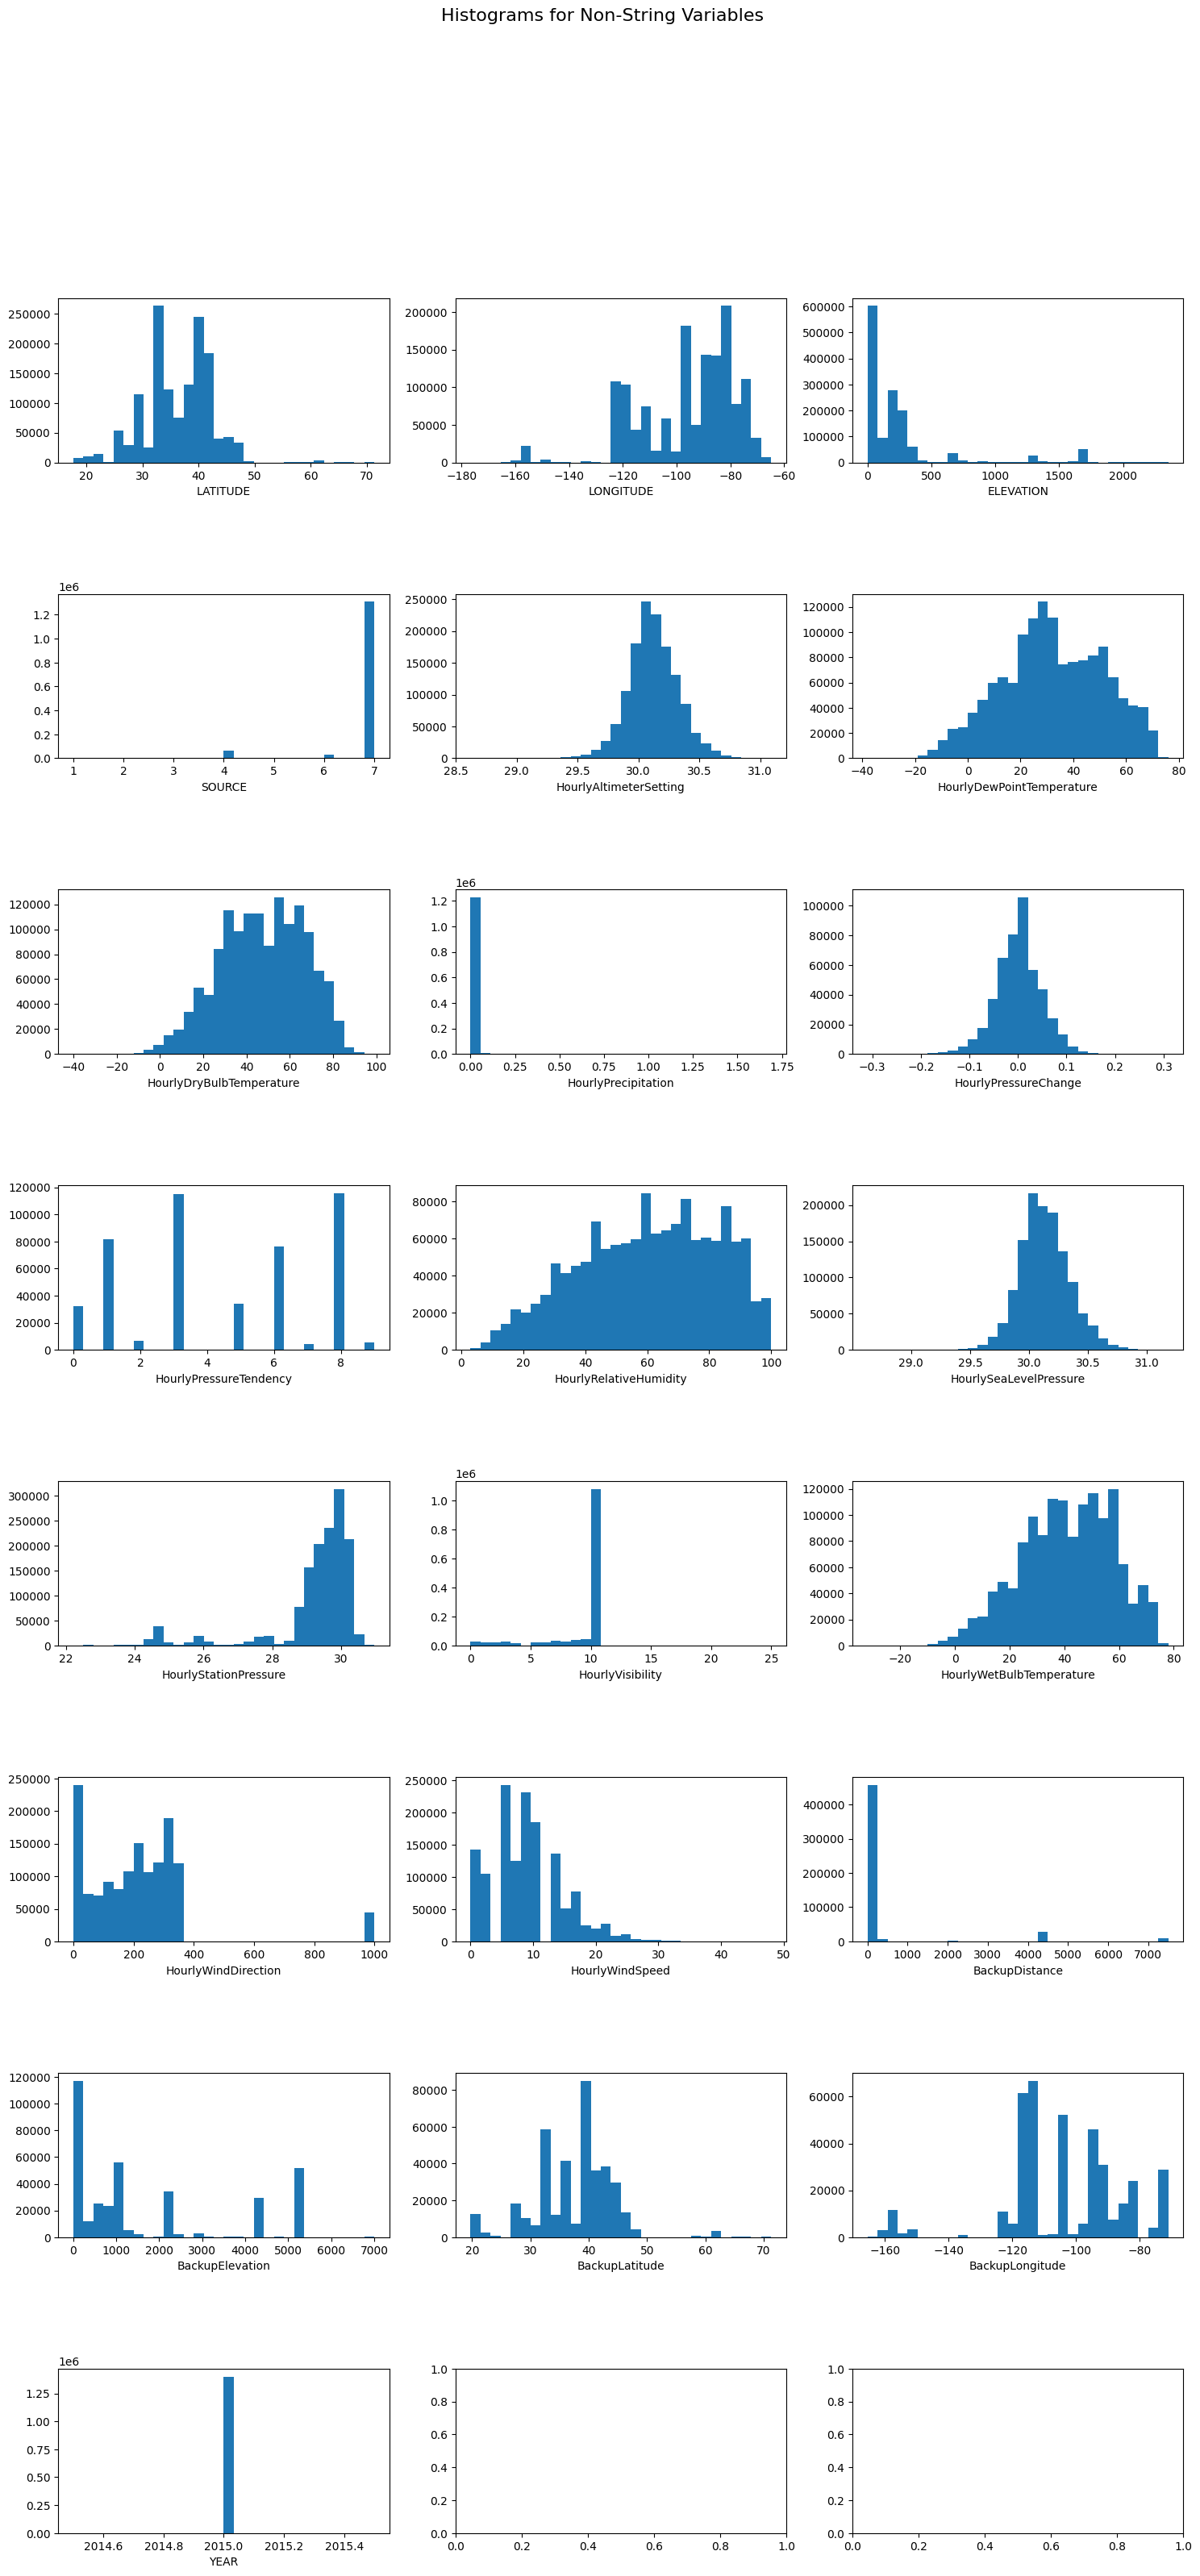

DataFrame[STATION: string, DATE: string, LATITUDE: float, LONGITUDE: float, ELEVATION: float, NAME: string, REPORT_TYPE: string, SOURCE: int, HourlyAltimeterSetting: float, HourlyDewPointTemperature: int, HourlyDryBulbTemperature: int, HourlyPrecipitation: float, HourlyPressureChange: float, HourlyPressureTendency: int, HourlyRelativeHumidity: int, HourlySkyConditions: string, HourlySeaLevelPressure: float, HourlyStationPressure: float, HourlyVisibility: float, HourlyWetBulbTemperature: int, HourlyWindDirection: float, HourlyWindSpeed: int, REM: string, BackupDirection: string, BackupDistance: float, BackupDistanceUnit: string, BackupElements: string, BackupElevation: int, BackupEquipment: string, BackupLatitude: float, BackupLongitude: float, BackupName: string, WindEquipmentChangeDate: string, YEAR: int]

In [0]:
# Get the non-string column names
non_string_cols = [col for col, dtype in otpw_weather_test_subset.dtypes if dtype not in ('string')]

# Cache the DataFrame
otpw_weather_test_subset.cache()

# Create a figure and axis subplots
num_cols = len(non_string_cols)
ncols = 3  
nrows = (num_cols + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 36))

# Flatten the axes
axes = axes.flatten()

# Loop through each non-string column and create a histogram
for idx, col in enumerate(non_string_cols):
    # Convert the column to a Pandas Series
    col_values = otpw_weather_test_subset.select(col).toPandas()[col]
    
    # Plot the histogram
    axes[idx].hist(col_values.dropna(), bins=30)
    axes[idx].set_xlabel(col)
    # axes[idx].set_title(f"{col}")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.8)

fig.suptitle("Histograms for Non-String Variables", fontsize=16)

# Show the plot
plt.show()

# Unpersist 
otpw_weather_test_subset.unpersist()

## 5. Summary statistics

### String variables: 

- STATION: Code for weather station (will have only one code, regardless of weather it has a backup station)
- DATE: Dates between xxxxx AND xxxx
- NAME: Station Name, for stations found at airports
- REPORT_TYPE: Code for report type, indicating type of weather observation
- HourlyPressureChange: Change in pressure. + or - amounts versus last hour. 
- HourlySkyConditions: A report of each cloud layer (up to 3) giving several conditions. 
- REM: Remarks. Includes a date, a time, and other things. **REVIEW DATA DICTIONARY TO UNDERSTAND MORE**
- BackupDirection: Additional direction information on wind direction from additional station **DROP - IF 2ND STATION FAR**
- BackupDistanceUnit: Additional direction information on wind distance unit from additional station  **DROP - IF 2ND STATION FAR**
- BackupElements: Weather elements in backup station (i.e. precipitation, snowfall, snowdepth)  **DROP - IF 2ND STATION FAR**
- BackupEquipment: Equipment at additonal station  **DROP - IF 2ND STATION FAR**
- BackupName: Station Name, for stations not found at airports  **DROP - IF 2ND STATION FAR**
- WindEquipmentChangeDate: additional wind equipment change date information relevant to observation stations  **DROP - IF 2ND STATION FAR**




In [0]:
string_cols = [col for col, dtype in otpw_weather_test_subset.dtypes if dtype in ('string')]
string_subset = otpw_weather_test_subset.select(*[F.col(c) for c in string_cols])

display(string_subset)
# for col in string_cols:
#         print(f"Number of unique values in '{col}' column: {otpw_weather_test_subset.select(col).distinct().count()}")

## 6. Correlations of variables we want to keep

- Columns with 80% or fewer nulls.
- With mean imputing


In [0]:
#drop backup columns BackupDistance:float
columns_to_drop = ['BackupDistance', 'BackupElevation', 'BackupLatitude', 'BackupLongitude']
numeric_subset = numeric_subset.drop(*columns_to_drop)

In [0]:
# Impute missing values

# Get the list of numeric column names
numeric_cols = numeric_subset.columns

# Create input and output column names
input_cols = numeric_cols
output_cols = [f"{col}" for col in numeric_cols]

# Create the Imputer instance
imputer = Imputer(inputCols=input_cols, outputCols=output_cols)

# Fit and transform the data
imputed_data = imputer.fit(numeric_subset).transform(numeric_subset)

In [0]:
#check dimensions to make sure nothing got lost
print(f'There are {imputed_data.count()} rows and {len(imputed_data.columns)} columns in the imputed_df dataframe')


There are 1401363 rows and 17 columns in the imputed_df dataframe


In [0]:
# pretty print variable names 
new_col = ['Latitude','Longitude','Elevation','Source','Altimeter Setting','Hourly Dew Point Temperature','Hourly Dry Bulb Temperature','Hourly Precipitation','Hourly Pressure Change','Hourly Pressure Tendency','Hourly Relative Humidity','Hourly Sea Level Pressure','Hourly Station Pressure','Hourly Visibility','Hourly Wet Bulb Temperature','Hourly Wind Direction','Hourly Wind Speed']

for_corr_df = imputed_data.select([imputed_data[old].alias(new) for old, new in zip(imputed_data.columns, new_col)])

# Calculate the correlation matrix
correlation_matrix = for_corr_df.toPandas().corr()

In [0]:
# Generate the heatmap
plt.figure(figsize=(15, 12))
plt.title('Correlations between numerical weather variables with < 80% nulls. Imputing = mean imputing')
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", annot_kws={"fontsize": 12}, fmt=".1f")
plt.tight_layout()
plt.savefig('weatherheatmap.png', dpi=300)


## 7. Variables we want to keep
The following variables are densely populated, show no high colineality, are available on an hourly basis, and are relevant to our study: 

In bold, also suggested by Rachel as "to keep"

- **Station**
- **Date**
- **Latitude**
- **Longitude**
- **Elevation**
- Name 
- Report Type
- **Hourly Dew Point Temperature**
- **Hourly Relative Humidity**
- **Hourly Station Pressure**
- **Hourly Wet Bulb Temperature**
- **Hourly Wind Direction**
- **Hourly Wind Speed**


Rachel suggests dropping Name due to redundancy with Station, and Report Type based on irrelevance. 



### Further analysis into REPORT_TYPE, HourlySkyConditions, REM, WindEquipmentChangeDate 

**REPORT_TYPE**
- SHEF: Standard Hydrologic Exchange Format
- FM-15: METAR Aviation routine weather report
- SOD: Summary of day report from U.S. ASOS or AWOS station **Maybe drop?**
- SY-MT: Synoptic and METAR merged report
- FM-12: SYNOP Report of surface observation form a fixed land station
- FM-16: SPECI Aviation selected special weather report

**HourlySkyConditions**
- 38821 unique
- Includes codes for cloud cover. BKN = broken cloud amount. 
- Future inspection in phase 2.  

**REM**
- 268358 unique


**WindEquipmentChangeDate**
- **DROP: NOT ENOUGH INFORMATION IN THE DATA DICTIONARY**
- 137
- DDDD-MM-DD

In [0]:
columns = ['REPORT_TYPE', 'HourlySkyConditions', 'REM', 'WindEquipmentChangeDate']

inspect_df = otpw_weather_test_subset.select(*columns)
# display(inspect_df)

In [0]:
# find unique values for each 
for column in inspect_df.columns:
    display(inspect_df.select(column).distinct().count())
    inspect_df.select(column).distinct().show()

## 8. Check to see if there's data available for every hour of every day in 2015, in order to select variables for training

In [0]:
# split DATE into two columns, Date and Time. 
# 2015-01-10T13:53:00
from pyspark.sql.window import Window
from pyspark.sql.functions import hour, day, year, month, split

In [0]:
otpw_weather_test_subset = otpw_weather_test_subset.withColumn("DATE", otpw_weather_test_subset["DATE"].cast("string"))


In [0]:
# Extract the hour, day of the year, and year from the DATE column
otpw_weather_test_subset = otpw_weather_test_subset.withColumn("hour", F.expr("split(DATE, 'T')[1]").substr(1, 2).cast("int"))
otpw_weather_test_subset = otpw_weather_test_subset.withColumn("day", day("DATE")) #of the month
otpw_weather_test_subset = otpw_weather_test_subset.withColumn("month", month("DATE"))
otpw_weather_test_subset = otpw_weather_test_subset.withColumn("year", year("DATE"))


In [0]:
columns = ['DATE','year','month', 'day', 'hour']

inspect_df = otpw_weather_test_subset.select(*columns)
# display(inspect_df)

In [0]:
# Define year
target_year = 2015

# Create DataFrames for all days and months
all_days = spark.range(1, 32).toDF("day")  
all_months = spark.range(1, 13).toDF("month")

# Create a DataFrame with all day-month combinations for the target year
day_month_df = all_days.crossJoin(all_months).withColumn("year", lit(target_year))

# Broadcast the DataFrame with all day-month combinations 
# day_month_df_broadcasted = day_month_df.broadcast()

# Join original dataframe with the broadcasted day-month combinations
joined_df = otpw_weather_test_subset.join(day_month_df, on=["year", "month", "day"], how="left")

# Filter rows where hour is null (unaccounted hours)
unaccounted_hours = joined_df.where(col("hour").isNull())

# Display the unaccounted day-month-hour combinations
display(unaccounted_hours)